# German Speed Limit Sign Recognition with Tensorflow and Keras

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from distutils.version import StrictVersion

In [4]:
import sklearn

# should at least be 0.18
assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

sklearn.__version__

'0.18.1'

In [5]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# should at least be 1.0
assert StrictVersion(tf.__version__) >= StrictVersion('1.0.0')

tf.__version__

'1.0.0'

In [6]:
import keras as keras

# should at least be 1.2 and use TensorFlow backend
assert StrictVersion(keras.__version__) >= StrictVersion('1.2.2')

keras.__version__

Using TensorFlow backend.


'2.0.3'

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

# Step 2: Understanding the Challenge and Prepare the Data

In [9]:
!ls -l ../../data/speed-limit-signs

total 35012
drwxrwxrwx 0 root root 512 Mar  5 23:09 0
drwxrwxrwx 0 root root 512 Mar  5 23:09 1
drwxrwxrwx 0 root root 512 Mar  5 23:09 2
drwxrwxrwx 0 root root 512 Mar  5 23:09 3
drwxrwxrwx 0 root root 512 Mar  5 23:09 4
drwxrwxrwx 0 root root 512 Mar  5 23:09 5
-rwxrwxrwx 1 root root 380 Mar  5 23:09 README.md


In [10]:
!cat ../../data/speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

In [11]:
!ls ../../data/speed-limit-signs/0

00000.ppm  00012.ppm  00024.ppm  00036.ppm  00048.ppm  00060.ppm  00072.ppm
00001.ppm  00013.ppm  00025.ppm  00037.ppm  00049.ppm  00061.ppm  00073.ppm
00002.ppm  00014.ppm  00026.ppm  00038.ppm  00050.ppm  00062.ppm  00074.ppm
00003.ppm  00015.ppm  00027.ppm  00039.ppm  00051.ppm  00063.ppm  00075.ppm
00004.ppm  00016.ppm  00028.ppm  00040.ppm  00052.ppm  00064.ppm  00076.ppm
00005.ppm  00017.ppm  00029.ppm  00041.ppm  00053.ppm  00065.ppm  00077.ppm
00006.ppm  00018.ppm  00030.ppm  00042.ppm  00054.ppm  00066.ppm  00078.ppm
00007.ppm  00019.ppm  00031.ppm  00043.ppm  00055.ppm  00067.ppm
00008.ppm  00020.ppm  00032.ppm  00044.ppm  00056.ppm  00068.ppm
00009.ppm  00021.ppm  00033.ppm  00045.ppm  00057.ppm  00069.ppm
00010.ppm  00022.ppm  00034.ppm  00046.ppm  00058.ppm  00070.ppm
00011.ppm  00023.ppm  00035.ppm  00047.ppm  00059.ppm  00071.ppm


## Analyse and Prepare Image Data

In [12]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [13]:
# Load datasets.
ROOT_PATH = "../../data/"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [14]:
len(set(labels)), len(images)

(6, 379)

In [15]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

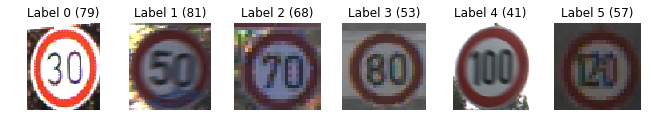

In [16]:
display_images_and_labels(images, labels)

In [17]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (61, 51, 3), min: 0, max: 255
shape: (55, 56, 3), min: 0, max: 255
shape: (80, 77, 3), min: 0, max: 255
shape: (41, 40, 3), min: 34, max: 255
shape: (32, 32, 3), min: 8, max: 255


In [18]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [19]:
for image in images64[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (64, 64, 3), min: 0.025211109834559136, max: 1.0
shape: (64, 64, 3), min: 0.0004308363970588852, max: 1.0
shape: (64, 64, 3), min: 0.011462162990196529, max: 1.0
shape: (64, 64, 3), min: 0.13649854473039216, max: 1.0
shape: (64, 64, 3), min: 0.05343137254901961, max: 1.0


In [20]:
import numpy as np

y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

# Step 3: Choosing the right architecture

## Training a simple Keras model

In [21]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

### Starting with one fully connected layer and a softmax output

In [23]:
# https://keras.io/getting-started/functional-api-guide/
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(256, activation='relu')(inputs)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

In [24]:
model.input_shape

(None, 64, 64, 3)

In [25]:
model.output_shape

(None, 6)

### Keras Models need to be compiled (to TensorFlow in our case) before usage

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### First let make a sense check of the architecture, will it be sufficient? To do so try to overfit it with a very small set of data: http://cs231n.github.io/neural-networks-3/#sanitycheck

In [27]:
from sklearn.model_selection import train_test_split

In [63]:
# http://cs231n.github.io/neural-networks-3/#sanitycheck
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=4)

In [64]:
# we are only interested in the training data (0.5 % of ~400 = ~20)
X_train.shape, y_train.shape

((18, 64, 64, 3), (18, 6))

In [30]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tensorboard/README.md
# https://keras.io/callbacks/#tensorboard
# http://stackoverflow.com/questions/42112260/how-do-i-use-the-tensorboard-callback-of-keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/mnt/c/Users/olive/Development/ml/tf_log', histogram_freq=1, write_graph=True, write_images=True)
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log

In [32]:
from datetime import tzinfo, timedelta, datetime

In [33]:
print(datetime.utcnow().isoformat())
model.fit(X_train, y_train, nb_epoch=50, batch_size=32, callbacks=[tbCallBack])
print(datetime.utcnow().isoformat())

2017-04-27T16:19:05.162819
Epoch 1/100
18/18 [==============================] - 1s - loss: 1.7991 - acc: 0.2222
Epoch 2/100
18/18 [==============================] - 1s - loss: 11.3680 - acc: 0.2778
Epoch 3/100
18/18 [==============================] - 1s - loss: 9.9840 - acc: 0.3333
Epoch 4/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 5/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 6/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 7/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 8/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 9/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 10/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 11/100
18/18 [==============================] - 1s - loss: 11.6408 - acc: 0.2778
Epoch 12/100
18/18 [=======

### Nope, not good, stuck at low accuracy: if we can not even perfectly match the very small test data, probably not a good model

### Let's try 4 times as many neurons, because it might work: http://cs231n.github.io/neural-networks-1/#power

In [34]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(1024, activation='relu')(inputs)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(X_train, y_train, nb_epoch=100, batch_size=100)

In [35]:
print(datetime.utcnow().isoformat())
model.fit(X_train, y_train, nb_epoch=50, batch_size=32, callbacks=[tbCallBack])
print(datetime.utcnow().isoformat())

2017-04-27T16:23:47.488456
Epoch 1/100
18/18 [==============================] - 6s - loss: 1.7868 - acc: 0.2778
Epoch 2/100
18/18 [==============================] - 6s - loss: 11.6408 - acc: 0.2778
Epoch 3/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 4/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 5/100
18/18 [==============================] - 6s - loss: 11.6408 - acc: 0.2778
Epoch 6/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 7/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 8/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 9/100
18/18 [==============================] - 5s - loss: 11.6408 - acc: 0.2778
Epoch 10/100
18/18 [==============================] - 6s - loss: 11.6408 - acc: 0.2778
Epoch 11/100
18/18 [==============================] - 7s - loss: 11.6408 - acc: 0.2778
Epoch 12/100
18/18 [======

### Same problem, what about a second hidden layer, because pratically more than on layer makes training feasible in the first place

In [60]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(512, activation='relu')(inputs)
x = Dense(512, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(X_train, y_train, nb_epoch=30, batch_size=100)

In [65]:
print(datetime.utcnow().isoformat())
model.fit(X_train, y_train, nb_epoch=30, batch_size=32, callbacks=[tbCallBack])
print(datetime.utcnow().isoformat())

2017-04-27T18:05:19.675852
Epoch 1/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 2/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 3/30
18/18 [==============================] - 6s - loss: 14.3272 - acc: 0.1111
Epoch 4/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 5/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 6/30
18/18 [==============================] - 6s - loss: 14.3272 - acc: 0.1111
Epoch 7/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 8/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 9/30
18/18 [==============================] - 6s - loss: 14.3272 - acc: 0.1111
Epoch 10/30
18/18 [==============================] - 6s - loss: 14.3272 - acc: 0.1111
Epoch 11/30
18/18 [==============================] - 5s - loss: 14.3272 - acc: 0.1111
Epoch 12/30
18/18 [=================

### Should be better and depending on our luck, with same amount of neurons, but we can actually overfit

In [66]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

18/18 [==============================] - 2s


(14.32719612121582, 0.1111111119389534)

### But on unknown data of course we totally suck

In [67]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

361/361 [==============================] - 34s     


(12.680163753329882, 0.21329639897452166)

### Bad result for test data was to be expected, because we were overfitting on purpose, now take a more reasonable split and try not to overfit too much

### Split training (80%) from test data (%20) (and make it reproduceable)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Training now takes far longer, as we have far more data, even on a very powerful machine, this might take up to 15 minutes, do not run this, unless you have time and a big machine

In [69]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

# reduced to make this terminate in a reasonable amout of time
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
# x = Dense(512, activation='relu')(inputs)
# x = Dense(512, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
print(datetime.utcnow().isoformat())
# comment it in again if you really want to give it a try...
model.fit(X_train, y_train, nb_epoch=30, batch_size=32, callbacks=[tbCallBack])
print(datetime.utcnow().isoformat())

2017-04-27T18:08:55.601948
Epoch 1/30
303/303 [==============================] - 13s - loss: 6.2462 - acc: 0.2013     
Epoch 2/30
303/303 [==============================] - 13s - loss: 1.5978 - acc: 0.3630     

In [71]:
# if accuracy is still not close to 1, run this as many times as necessary 
# model.fit(X_train, y_train, nb_epoch=10, batch_size=100, callbacks=[tbCallBack])

In [72]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 5s     


(0.28676607145039557, 0.92409240924092406)

In [73]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

76/76 [==============================] - 1s     


(1.9811498616871082, 0.67105263157894735)

### This takes a lot of time to train, and still sucks on test data, can we do better?

# Step 4: Convolutional Neural Networks

## Turns out we can use a standard CNN model with many more layers, but far less neurons

### Layout of a typical CNN

![Layout of a typical CNN](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/convnet-layoyt.jpeg)
http://cs231n.github.io/convolutional-networks/

## Classic VGG like Architecture
* we use a VGG like architecture
* based on https://arxiv.org/abs/1409.1556
* basic idea: sequential, deep, small convolutional filters, use dropouts to reduce overfitting
* 16/19 layers are typical
* we choose less layers, because we have limited resources

In [37]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

### Input Layer: Not strictly speaking a real layer, just interface to input

In [38]:
# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

### Convolutional Blocks: Cascading many Convolutional Layers having down sampling in between

![Applying filters](http://cs231n.github.io/assets/cnn/cnn.jpeg)

http://cs231n.github.io/convolutional-networks/#conv

In [39]:
# one block of convolutional layers

# 32 filters with a 4x4 kernel, outputs 64x64x32 tensor
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(inputs)
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(x)
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(x)

### Example of a Convolution
#### Original Image
![Dog](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog.png)
#### Many convolutional filters applied over all channels
![Dog after Convolutional Filters applied](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog-conv1.png)
http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

### Downlsampling Layer: Reduces data sizes and risk of overfitting
![Pooling](http://cs231n.github.io/assets/cnn/pool.jpeg)
![Max Pooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)
http://cs231n.github.io/convolutional-networks/#pool

In [40]:
# max pooling with 2x2 window, reducing data to a fourth
x = MaxPooling2D(pool_size=(2, 2))(x)

In [41]:
# drops 25% of all connections, Also reduces risk of overfitting
x = Dropout(0.25)(x)

In [42]:
# one more block
x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

### Last Two Layers are typically again standard

In [43]:
x = Flatten()(x)
# fully connected, 256 nodes
x = Dense(256, activation='relu')(x)
x = Dropout(0.50)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [1]:
# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'Model' is not defined

In [2]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tensorboard/README.md
# https://keras.io/callbacks/#tensorboard
# http://stackoverflow.com/questions/42112260/how-do-i-use-the-tensorboard-callback-of-keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/mnt/c/Users/olive/Development/ml/tf_log/conv', histogram_freq=1, write_graph=True, write_images=True)
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log/conv

NameError: name 'keras' is not defined

In [47]:
print(datetime.utcnow().isoformat())
model.fit(X_train, y_train, nb_epoch=50, batch_size=32, callbacks=[tbCallBack])
print(datetime.utcnow().isoformat())

2017-04-27T16:35:21.695825
Epoch 1/50
303/303 [==============================] - 27s - loss: 1.8386 - acc: 0.3036     
Epoch 2/50
303/303 [==============================] - 26s - loss: 1.5410 - acc: 0.4092     

In [48]:
# again, if accuracy is still not close to 1, run this as many times as necessary 
model.fit(X_train, y_train, nb_epoch=5, batch_size=32, callbacks=[tbCallBack])

Epoch 1/5
303/303 [==============================] - 30s - loss: 2.1191 - acc: 0.8548     
Epoch 2/5
303/303 [==============================] - 39s - loss: 1.4412 - acc: 0.9010     

![Accuracy over Time](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/tensorboard/acc.png)
![Loss over Time](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/tensorboard/loss.png)
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tensorboard/README.md

# Step 5: Validation

In [49]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 10s     


(1.1920928955078125e-07, 1.0)

In [50]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

76/76 [==============================] - 2s     


(0.64219865673466736, 0.96052631578947367)

## Might be up to 90% accuracy on Test Data, great result

### Let us try a few random samples on the test data

In [51]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [52]:
sample_labels

[array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.])]

In [53]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([4, 0, 0, 2, 1, 1, 0, 3, 5, 0])

In [54]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [55]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([4, 0, 0, 2, 1, 1, 0, 3, 5, 0])

In [56]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Visualizing where we were right (might be up to 10 out of 10)

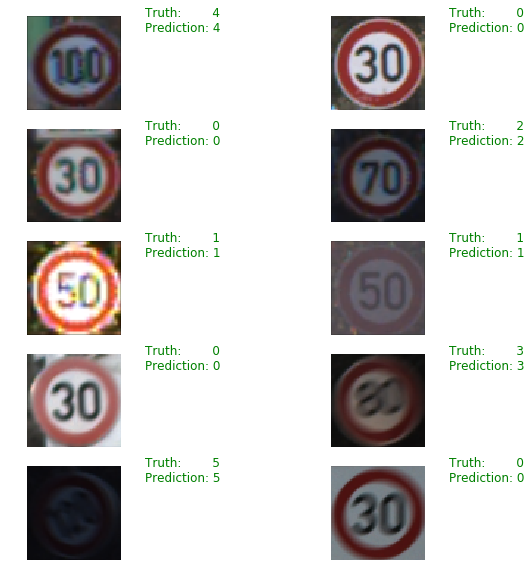

In [57]:
display_prediction(sample_images, ground_truth, predicted_categories)

# Step 6: Save model for later predictions and comparison

In [58]:
model.save('models/conv-vgg.h5')

In [59]:
# use the Data Menu Item to download from this directory
!ls -l models

total 18345985
-rwxrwxrwx 1 root root  2010088 Apr 27 09:27 conv-residual.h5
-rwxrwxrwx 1 root root 34676904 Apr 27 19:59 conv-vgg.h5
